# Day3 課題

## 1. 概要
以下をそれぞれ行う。

- 前回内容の再検討
- 特徴量選択
- 木モデル
- ランダムフォレスト
- アダブースト
- ニューラルネットワーク



## 2. 前回の内容の再検討
前回の内容の間違っていた点の再検討を行い、比較用の結果を出しておく。

### クラス定義

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import math

from abc import ABCMeta, abstractmethod # 抽象クラス用

from sklearn.preprocessing import MinMaxScaler # 正規化関数
from sklearn.preprocessing import StandardScaler # 標準化関数

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression, SGDClassifier


from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing


from tensorflow import keras  
import tensorflow as tf

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

In [3]:
# Kickstarterデータのクラス化
# ファイルを読み込み、使用する変数などを指定して、最終的にデータフレームを取得する。
class Ks_data():
    DATA_FILE = "../1_data/ks-projects-201801.csv" # 初期ファイル名
    
    OBJ_VAR_NAME = "state_bool" # 目的変数名
    PRE_OBJ_VAR_NAME = "state" # 変換前の目的変数
    PRE_OBJ_VAR_SUCC = "successful" # 成功
    PRE_OBJ_VAR_FAIL = "failed" # 失敗
    
    USD_GOAL_REAL = "usd_goal_real" # ドル換算の目標金額
    LOG_USD_GOAL_REAL = "log_usd_goal_real" # ドル換算の目標金額のlog
    DAYS = "days" # 期間
    LAUNCHED_MONTH = "launched_month" # 開始月
    DEADLINE_MONTH = "deadline_month" # 終了月
    LAUNCHED = "launched" # 開始日付
    DEADLINE = "deadline" # 終了日付
    
    NAME = "name" # 名前
    NAME_LEN = "name_len" # 名前の長さ
    NAME_INIT = "name_init" # 　名前の頭文字
    
    COUNTRY = "country" # 国
    US = "US" # US
    
    quant_var_list = [LOG_USD_GOAL_REAL, DAYS, NAME_LEN] # 量的変数のリスト
    quality_var_list = ["main_category","category","country", LAUNCHED_MONTH, DEADLINE_MONTH, NAME_INIT] # 質的変数のリスト
    disposal_item_list = [PRE_OBJ_VAR_NAME,"goal","ID",NAME,"currency",DEADLINE, LAUNCHED, "pledged","backers","usd pledged", USD_GOAL_REAL,"usd_pledged_real"] #　初期廃棄項目のリスト
    
    # ドル換算の目標金額をlog10で変換し、格納し、元の目的変数を削除
    def __trans_log_usd_goal_real(self,df_arg):
        log_usd_goal_real_func = lambda x : math.log10(x)
        df_arg.loc[df_arg[self.USD_GOAL_REAL].isnull() == False, self.LOG_USD_GOAL_REAL]  \
            = df_arg[self.USD_GOAL_REAL].map( log_usd_goal_real_func)
        return df_arg

    # 目的変数の変換
    def __trans_obj_var(self,df_arg):
        # stateがsuccessful,faild以外のものを削除
        df_arg = \
            df_arg[ \
                       (df_arg[self.PRE_OBJ_VAR_NAME] == self.PRE_OBJ_VAR_SUCC)| \
                       (df_arg[self.PRE_OBJ_VAR_NAME] == self.PRE_OBJ_VAR_FAIL) ].copy()
        
        # 目的変数をTrue,Falseに変換
        df_arg.loc[df_arg[self.PRE_OBJ_VAR_NAME] == self.PRE_OBJ_VAR_SUCC, self.OBJ_VAR_NAME] = True
        df_arg.loc[df_arg[self.PRE_OBJ_VAR_NAME] != self.PRE_OBJ_VAR_SUCC, self.OBJ_VAR_NAME] = False
        return df_arg
    
    # 期間、開始日時の月、終了日時の月を項目として加える関数
    def __add_item_days_month(self,df_arg):
        # 期間算出
        df_arg.loc[df_arg[self.DEADLINE].isnull() == False, self.DAYS] \
            = df_arg.apply(lambda x: (dt.strptime(x[self.DEADLINE], '%Y-%m-%d') \
                - dt.strptime(x[self.LAUNCHED], '%Y-%m-%d %H:%M:%S')).days , axis=1)

        # 月算出
        launched_month_func = lambda launched : dt.strptime(launched, '%Y-%m-%d %H:%M:%S').month
        df_arg.loc[df_arg[self.LAUNCHED].isnull()==False, self.LAUNCHED_MONTH] \
            = df_arg[self.LAUNCHED].map( launched_month_func)

        deadline_month_func = lambda deadline : dt.strptime(deadline, '%Y-%m-%d').month
        df_arg.loc[df_arg[self.DEADLINE].isnull()==False, self.DEADLINE_MONTH] \
            = df_arg[self.DEADLINE].map( deadline_month_func)
        return df_arg
    
    def __trans_name(self, df_arg):
        # name でnan値が入っているので、空白で置換え
        df_arg[self.NAME] = df_arg[self.NAME].fillna(" ")
        # 名前の長さの算出
        df_arg.loc[:,self.NAME_LEN] = df_arg[self.NAME].map(lambda name: len(name))
        # 名前の頭文字の算出
        df_arg.loc[df_arg[self.NAME_LEN] >= 1, self.NAME_INIT] = df_arg[self.NAME].map(lambda name: name[0:1])
        return df_arg
    
    # コンストラクタ
    def __init__(self):
        # 初期ファイルの読み込み
        self.df_ks = pd.read_csv(self.DATA_FILE)
        
        #　目的変数の処理
        self.df_ks_result = self.__trans_obj_var(self.df_ks)
        
        # 目標金額の処理                                  
        # ドル換算の目標金額のlog変換
        self.df_ks_result = self.__trans_log_usd_goal_real(self.df_ks_result)
        
        # 開始日付、終了日付の処理
        # 期間、開始月、終了月の処理
        self.df_ks_result = self.__add_item_days_month(self.df_ks_result)
        
        # 名前の処理
        self.df_ks_result = self.__trans_name(self.df_ks_result)
        
        # 不必要項目の一括削除
        self.df_ks_result = self.df_ks_result.drop(self.disposal_item_list, axis=1)
        
        
        
    # 目的変数のアイテム名の取得
    def get_obj_var_name(self):
        return self.OBJ_VAR_NAME
    
    # 量的変数の項目名取得
    def get_quant_var_list(self):
        return self.quant_var_list
    
    # 量的変数の選択設定
    def set_quant_var(self,quant_var_list):
        quant_var_del_list = set(self.quant_var_list) -  set(quant_var_list)
        self.quant_var_list = quant_var_list
        
        # 必要のない量的変数を削除
        self.df_ks_result = self.df_ks_result.drop(quant_var_del_list, axis=1)
        return
    
    # 質的変数の項目名取得
    def get_quality_var_list(self):
        return self.qunt_var_list
    
    # 質的変数の選択設定
    def set_quality_var(self, quality_var_list):
        quality_var_del_list = set(self.quality_var_list) -  set(quality_var_list)
        self.quality_var_list = quality_var_list
        
        # 必要のない質的変数の削除
        self.df_ks_result = self.df_ks_result.drop(quality_var_del_list, axis=1)
        
        return
    
    # 質的変数の全ダミー化
    def set_dummy(self):
        # 削除されていない質的変数をダミー化
        self.df_ks_result = pd.get_dummies(self.df_ks_result,  columns=self.quality_var_list ,drop_first = True)
        return
    
    # 質的変数のダミー化
    # ただし、国のUSだけ突出しているため、countryはUSのみダミー変数とし、それ以外は全部まとめてダミー変数化しない
    def set_dummy_country(self):
        quality_var_list_tmp = self.quality_var_list
        
        # 質的変数にcountryが含まれているか？
        if self.COUNTRY in self.quality_var_list:
            # countryを一旦抜く
            quality_var_list_tmp.remove(self.COUNTRY)
            
            # countryをUSのみダミー変数化(country_USの項目を追加)
            item = self.COUNTRY + "_" + self.US
            self.df_ks_result[item] = self.df_ks_result[self.COUNTRY].apply(lambda x: 1 if x== self.US else 0)
            
            # countryの項目を落とす。
            self.df_ks_result = self.df_ks_result.drop(self.COUNTRY,axis=1)
        
        # country以外のダミー変数化
        self.df_ks_result = pd.get_dummies(self.df_ks_result,  columns=quality_var_list_tmp ,drop_first = True)        
        return
    
    # 質的変数のラベル化
    def set_label(self):
        self.label_dict = {}
        for item in self.quality_var_list:
            # ラベルエンコーディング
            self.label_dict[item] =  preprocessing.LabelEncoder()
            self.label_dict[item].fit(self.df_ks_result[item])
            self.df_ks_result[item] = self.label_dict[item].transform(self.df_ks_result[item])
            
    # 質的変数のラベルのインデックス取得       
    def get_label_index(self, item):
        return self.label_dict[item].classes_
    
    # データフレームの戻し
    def get_df(self):
        return self.df_ks_result
    

In [4]:
# 検証用抽象クラス
class Valid(metaclass=ABCMeta):

    # コンストラクタ（必須）
    @abstractmethod
    def __init__(self):
        pass

    # 実行メソッド(必須)
    @abstractmethod
    def run(self):
        pass
    
    
    OBJ_VAR_NAME = "state_bool" # 目的変数名   
    
    # 標準化変数の辞書型配列の作成（量的変数毎の標準化変数をいれる枠）
    def __make_stdsc_dict(self):            
        stdsc_dict = {}
        for item in self.quant_var_list:
            stdsc_dict[item] = StandardScaler()
        return stdsc_dict
    
    # 量的変数の標準化処理
    # df　: 対象データフレーム
    # stdsc :標準化
    # fit_bool : fit_transformならTrue, transformならFalse
    def __trans_stdsc(self, df, stdsc_dict,fit_bool):
        for item in self.quant_var_list:
            if fit_bool == True:    
                df.loc[:,item]  = stdsc_dict[item].fit_transform(df[item].to_numpy().reshape(-1,1).astype('float64'))       
            else:
                df.loc[:,item]  = stdsc_dict[item].transform(df[item].to_numpy().reshape(-1,1).astype('float64'))
        return df
    
    # 訓練（予め指定したモデルのアルゴリズムを使用）
    def __train(self, X, y):
        clf = self.model_alg
        clf.fit(X, y)
        
        return clf

    def __print_result(self, title, logloss, accuracy, precision, recall, f1_score):
            print(title)
            print('対数尤度 = {:.3f}'.format(logloss))
            print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
            print('適合率（Precision） = {:.3f}%'.format(100 * precision))
            print('再現率（Recall） = {:.3f}%'.format(100 * recall))
            print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score))
            print('\n')
            
    # 結果の表示
    def __get_result(self, y, y_est):
        # 対数尤度を表示
        logloss = - log_loss(y, y_est)
              
        # 正答率を計算
        accuracy =  accuracy_score(y, y_est)

        # Precision, Recall, F1-scoreを計算
        precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
        
        return logloss,accuracy,precision[1],recall[1],f1_score[1]
    
    
    # 検証
    def __valid(self, df_train, df_test, stdsc_dict):
        
        # 訓練データとテストデータを目的変数と説明変数に分ける。
        y_train = df_train[self.OBJ_VAR_NAME ].values
        X_train = df_train.drop(self.OBJ_VAR_NAME , axis=1) 
        y_test = df_test[self.OBJ_VAR_NAME ].values
        X_test = df_test.drop(self.OBJ_VAR_NAME , axis=1)        
        
        
        # 訓練データの量的変数の標準化処理
        X_train = self.__trans_stdsc(X_train, stdsc_dict, True)
        
        # モデルのアルゴリズムで訓練
        clf = self.__train(X_train, y_train)
        
        # 　テストデータの量的変数の標準化
        X_test = self.__trans_stdsc(X_test,stdsc_dict,False)
        
        # テストデータで検証
        y_est = clf.predict(X_test)
        logloss,accuracy,precision,recall,f1_score = self.__get_result(y_test,y_est)
        
        # 訓練結果を戻す。
        return clf, logloss, accuracy,precision,recall,f1_score
    


In [5]:
# ホールドアウト用クラス
class Valid_hold(Valid):
    
    #　コンストラクタ
    # df : 検証対象のデータ（データフレーム）
    # model_alg : モデルのアルゴリズム
    # hold_sep_num: ホールドアウト法における分割数(1/分割数をテストに回す)
    # cross_sep_num: 交差検証における分割数
    # quant_var_list : 標準化する量的変数のリスト
    def __init__(self,df, model_alg, hold_sep_num, quant_var_list):
        self.df = df
        self.model_alg = model_alg
        self.hold_sep_num = hold_sep_num
        self.quant_var_list = quant_var_list
        return

    
    # ホールドアウト法
    def __run_hold(self,df_test, clf, stdsc_dict):
        # テストデータを訓練データとテストデータに分割
        y_test = df_test[self.OBJ_VAR_NAME ].values
        X_test = df_test.drop(self.OBJ_VAR_NAME , axis=1)     

        # テストデータの標準化
        X_test = self._Valid__trans_stdsc(X_test, stdsc_dict, False)
        
         # テストデータで検証
        y_est = clf.predict(X_test)
        logloss, accuracy,precision,recall,f1_score = self._Valid__get_result(y_test, y_est)                                
        self._Valid__print_result('ホールドアウト検証結果',logloss, accuracy,precision,recall,f1_score)                                                 
        return
    
    # 検証の実行
    def run(self):
        # ホールドアウトの分割
        df_train, df_test= train_test_split(self.df, test_size=(1/self.hold_sep_num), random_state=1234)      
            
        stdsc_dict = self._Valid__make_stdsc_dict()
        
        # 訓練データによる訓練
        clf, logloss, accuracy,precision,recall,f1_score = self._Valid__valid(df_train, df_test, stdsc_dict)
        
        # ホールドアウトのテスト
        self.__run_hold(df_test,clf,stdsc_dict)
        
        # 内容を参照するため、モデルを返す。
        return clf

In [6]:
# ホールドアウト、交差検証用クラス
# GridSearchCVを使用しない場合はこちらを使用
class Valid_hold_cross(Valid_hold):
    
    #　コンストラクタ
    # df : 検証対象のデータ（データフレーム）
    # model_alg : モデルのアルゴリズム
    # hold_sep_num: ホールドアウト法における分割数(1/分割数をテストに回す)
    # cross_sep_num: 交差検証における分割数
    # quant_var_list : 標準化する量的変数のリスト
    def __init__(self,df, model_alg, hold_sep_num, cross_sep_num, quant_var_list):
        self.df = df
        self.model_alg = model_alg
        self.hold_sep_num = hold_sep_num
        self.cross_sep_num = cross_sep_num
        self.quant_var_list = quant_var_list
        return
    
    
    # 交差検証
    def __run_cross(self, df, stdsc_dict):
        # モデル配列定義
        clf_list = []
        cross_valid_mae  = 0
        
        # 受け取ったデータフレームを分割
        logloss_sum = 0
        accuracy_sum = 0
        precision_sum = 0
        recall_sum = 0
        f1_score_sum = 0
        for i, [train_idx, test_idx] in enumerate(KFold(n_splits=self.cross_sep_num, shuffle=True, random_state=1234).split(df)):
            df_train = df.iloc[train_idx] #学習用データ
            df_test = df.iloc[test_idx] #テスト用データ
            
            # 学習用データでモデル作成してモデル配列に追加
            stdsc_dict_tmp = self._Valid__make_stdsc_dict()

            clf, logloss, accuracy,precision,recall,f1_score = self._Valid__valid(df_train, df_test, stdsc_dict_tmp)
            # 結果表示
            self._Valid__print_result('{0}回目'.format(i),logloss, accuracy,precision,recall,f1_score)
            logloss_sum += logloss
            accuracy_sum += accuracy
            precision_sum += precision
            recall_sum += recall
            f1_score_sum += f1_score
            
            clf_list.append(clf)
                                                 
        # 交差検証した結果の平均化の表示
        self._Valid__print_result(\
                            '交差検証平均結果',\
                            (logloss_sum/self.cross_sep_num),\
                            (accuracy_sum/self.cross_sep_num),\
                            (precision_sum/self.cross_sep_num),\
                            (recall_sum/self.cross_sep_num),\
                            (f1_score_sum/self.cross_sep_num)\
                           )

        # 交差検証内の全データを使って、再度訓練（テスト結果は同じデータで表示
        clf, logloss, accuracy,precision,recall,f1_score = self._Valid__valid(df,df,stdsc_dict)
        self._Valid__print_result('交差検証全訓練データによる訓練結果',logloss, accuracy,precision,recall,f1_score)        
        
        # 訓練結果を戻す。
        return clf
    

    
    # 検証の実行
    def run(self):
        # ホールドアウトの分割
        df_train, df_test= train_test_split(self.df, test_size=(1/self.hold_sep_num), random_state=1234)      
            
        stdsc_dict = self._Valid__make_stdsc_dict()

        # ホールドアウトの訓練データを使用して交差検証
        clf = self.__run_cross(df_train, stdsc_dict)
        
        # ホールドアウトのテスト
        self._Valid_hold__run_hold(df_test,clf,stdsc_dict)
        
        # 内容を参照するため、モデルを返す。
        return clf
    

### データの構成

In [5]:
ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])

# 質的変数のダミー化
ks_data.set_dummy()

df_ks_result = ks_data.get_df()
df_ks_result.head()

,state_bool,log_usd_goal_real,days,name_len,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,...,deadline_month_3,deadline_month_4,deadline_month_5,deadline_month_6,deadline_month_7,deadline_month_8,deadline_month_9,deadline_month_10,deadline_month_11,deadline_month_12
0,False,3.185811,58,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,False,4.477121,59,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,False,4.653213,44,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,3.698970,29,49,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,True,4.698970,34,20,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### 交差検証およびホールドアウトの実行

In [7]:
# ロジスティック回帰で全データを使用
quant_var_list = ks_data.get_quant_var_list()
model_alg =SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
valid_hold_cross = Valid_hold_cross(df_ks_result, model_alg, 5, 5, quant_var_list)

valid_hold_cross.run()

0回目
対数尤度 = -11.273
正答率（Accuracy） = 67.363%
適合率（Precision） = 61.679%
再現率（Recall） = 51.485%
F1値（F1-score） = 56.123%


1回目
対数尤度 = -11.220
正答率（Accuracy） = 67.515%
適合率（Precision） = 61.769%
再現率（Recall） = 53.255%
F1値（F1-score） = 57.197%


2回目
対数尤度 = -11.135
正答率（Accuracy） = 67.760%
適合率（Precision） = 62.611%
再現率（Recall） = 50.126%
F1値（F1-score） = 55.677%


3回目
対数尤度 = -11.215
正答率（Accuracy） = 67.530%
適合率（Precision） = 62.001%
再現率（Recall） = 50.732%
F1値（F1-score） = 55.803%


4回目
対数尤度 = -11.265
正答率（Accuracy） = 67.385%
適合率（Precision） = 62.063%
再現率（Recall） = 48.467%
F1値（F1-score） = 54.429%


交差検証平均結果
対数尤度 = -11.221
正答率（Accuracy） = 67.511%
適合率（Precision） = 62.025%
再現率（Recall） = 50.813%
F1値（F1-score） = 55.846%


交差検証全訓練データによる訓練結果
対数尤度 = -11.204
正答率（Accuracy） = 67.563%
適合率（Precision） = 62.179%
再現率（Recall） = 50.601%
F1値（F1-score） = 55.796%


ホールドアウト検証結果
対数尤度 = -11.198
正答率（Accuracy） = 67.580%
適合率（Precision） = 61.677%
再現率（Recall） = 50.633%
F1値（F1-score） = 55.612%




SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

#### グリッドサーチの実行

In [8]:
parameters = { \
              'penalty':['none', 'l2','l1','elasticnet'], \
              'max_iter':[1000, 5000, 10000,50000], \
              'fit_intercept':[True, False] \
             }
model =  SGDClassifier(loss='log', random_state=1234, tol=1e-3)
model_alg= GridSearchCV(model, parameters, cv=3,)

quant_var_list = ks_data.get_quant_var_list()
valid_hold = Valid_hold(df_ks_result, model_alg, 5, quant_var_list)
clf = valid_hold.run()

print(clf.best_params_, clf.best_score_)

ホールドアウト検証結果
対数尤度 = -11.229
正答率（Accuracy） = 67.488%
適合率（Precision） = 61.537%
再現率（Recall） = 50.517%
F1値（F1-score） = 55.485%


{'fit_intercept': False, 'max_iter': 1000, 'penalty': 'elasticnet'} 0.6752053968493253


（考察）　上記を参考にする。

## 3. 特徴量選択

### フィルター法

#### 量的変数の検討
とりあえず量的変数での相関関係を検討してみる

In [9]:
# 説明変数の相関係数を確認

ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])

# 質的変数のダミー化
ks_data.set_dummy()

df_ks_result = ks_data.get_df()

In [10]:
df_ks_result[["state_bool","log_usd_goal_real","days","name_len"]].corr()

,state_bool,log_usd_goal_real,days,name_len
state_bool,1.000000,-0.224391,-0.116437,0.104378
log_usd_goal_real,-0.224391,1.000000,0.185500,0.042964
days,-0.116437,0.185500,1.000000,0.014485
name_len,0.104378,0.042964,0.014485,1.000000


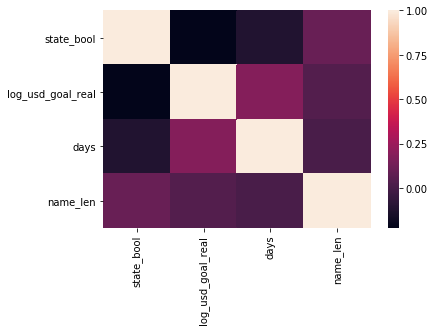

In [11]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_result[["state_bool","log_usd_goal_real","days","name_len"]].corr())
plt.show()

（考察）　量的変数で相関係数の高いもの（絶対値0.5を超えるようなもの）はない。

### ラッパー法

一度やろうとしたが、全部の変数を使用すると、計算が終わらない。

よって、countryはダミー変数としてcountry_USのみ採用する。

また、categoryとname_initは数が多すぎるため使用しない。

In [12]:
# estimatorにモデルをセット
estimator = SGDClassifier(loss='log', random_state=1234, tol=1e-3, fit_intercept=False, max_iter=1000, penalty='elasticnet')

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
rfecv = RFECV(estimator, cv=5, scoring='accuracy')

In [25]:
ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["main_category","country","launched_month","deadline_month"])

# 質的変数のダミー化(countryはcountry_USのみとする。)
ks_data.set_dummy_country()

df_ks_result = ks_data.get_df()

df_label = df_ks_result["state_bool"]
df_data = df_ks_result.drop("state_bool", axis=1)

y = df_label.values
X = df_data.values



In [26]:
# fitで特徴選択を実行
rfecv.fit(X, y)

RFECV(cv=5,
   estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=False,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [27]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 8 9 1 1 1 1 1 1 1 1 1 1 1 6 7 1 1 5 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 3]


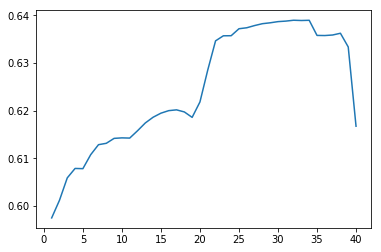

In [28]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [29]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([ True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False])

In [30]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True])

In [31]:
# 削除してもよい特徴の名前を取得する
remove_feature = df_data.columns[remove_idx]
remove_feature

Index(['days', 'name_len', 'main_category_Photography',
       'main_category_Publishing', 'launched_month_2', 'launched_month_3',
       'deadline_month_11', 'deadline_month_12'],
      dtype='object')

In [41]:
# drop関数で特徴を削除
selected_df_data = df_ks_result.drop(remove_feature, axis=1)
selected_df_data.head()

,state_bool,log_usd_goal_real,country_US,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,launched_month_12,deadline_month_2,deadline_month_3,deadline_month_4,deadline_month_5,deadline_month_6,deadline_month_7,deadline_month_8,deadline_month_9,deadline_month_10
0,False,3.185811,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,False,4.477121,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,False,4.653213,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,False,3.698970,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,True,4.698970,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [39]:
# グリッドサーチで計算してみる。
parameters = { \
    'penalty':['none', 'l2','l1','elasticnet'], \
    'max_iter':[1000, 5000, 10000,50000], \
    'fit_intercept':[True, False] \
    }

model =  SGDClassifier(loss='log', random_state=1234, tol=1e-3)
model_alg= GridSearchCV(model, parameters, cv=3,)

quant_var_list = ks_data.get_quant_var_list()

# 量的変数の中から削除対象があれば削除しておく。
for item in remove_feature:
    if item in quant_var_list:
        quant_var_list.remove(item)
        
valid_hold = Valid_hold(selected_df_data, model_alg, 5, quant_var_list)


In [40]:
clf = valid_hold.run()

print(clf.best_params_, clf.best_score_)

ホールドアウト検証結果
対数尤度 = -12.228
正答率（Accuracy） = 64.598%
適合率（Precision） = 58.446%
再現率（Recall） = 40.610%
F1値（F1-score） = 47.922%


{'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2'} 0.6397716137785483


（考察）
特徴量選択を行わない場合のグリッドサーチの結果は以下。

- ホールドアウト検証結果
    - 対数尤度 = -11.229
    - 正答率（Accuracy） = 67.488%
    - 適合率（Precision） = 61.537%
    - 再現率（Recall） = 50.517%
    - F1値（F1-score） = 55.485%

- 最適パラメータ
    - {'fit_intercept': False, 'max_iter': 1000, 'penalty': 'elasticnet'} 0.6752053968493253

　特にダミー変数が多くなると、計算量が多くなるので、変数を減らしたが、あまり良くなったとは言えない。

### 埋め込み法

In [136]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [151]:
ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])

# 質的変数のダミー化
ks_data.set_dummy()

df_ks_result = ks_data.get_df()


df_label = df_ks_result["state_bool"]
df_data = df_ks_result.drop("state_bool", axis=1)

y = df_label.values
X = df_data.values

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [152]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,

In [153]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
df_data.columns[removed_idx]

Index(['main_category_Dance', 'main_category_Design',
       'main_category_Film & Video', 'main_category_Games', 'category_Blues',
       'category_Children's Books', 'category_Comics', 'category_Design',
       'category_Drinks', 'category_Fantasy', 'category_Fashion',
       'category_Kids', 'category_Makerspaces', 'category_Pet Fashion',
       'category_Photography', 'category_Plays', 'category_Punk',
       'category_Puzzles', 'category_Quilts', 'category_Woodworking',
       'country_BE', 'country_CA', 'launched_month_8', 'deadline_month_7',
       'deadline_month_8', 'deadline_month_10', 'deadline_month_11',
       'name_init_$', 'name_init_*', 'name_init_1', 'name_init_5',
       'name_init_>', 'name_init_G', 'name_init__', 'name_init_j',
       'name_init_n', 'name_init_r', 'name_init_{', 'name_init_À',
       'name_init_í', 'name_init_—', 'name_init_•'],
      dtype='object')

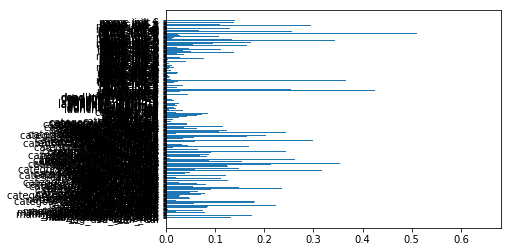

In [154]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_data.columns.values)
plt.show()

In [155]:
# 削除すべき特徴を削除して計算してみる。
delete_item = df_data.columns[removed_idx]
df_ks_result = df_ks_result.drop(delete_item,axis=1)

parameters = { \
    'penalty':['none', 'l2','l1','elasticnet'], \
    'max_iter':[1000, 5000, 10000,50000], \
    'fit_intercept':[True, False] \
    }

model =  SGDClassifier(loss='log', random_state=1234, tol=1e-3)
model_alg= GridSearchCV(model, parameters, cv=3,)

quant_var_list = ks_data.get_quant_var_list()
valid_hold = Valid_hold(df_ks_result, model_alg, 5, quant_var_list)
clf = valid_hold.run()

print(clf.best_params_, clf.best_score_)

ホールドアウト検証結果
対数尤度 = -11.179
正答率（Accuracy） = 67.634%
適合率（Precision） = 61.360%
再現率（Recall） = 52.144%
F1値（F1-score） = 56.378%


{'fit_intercept': True, 'max_iter': 1000, 'penalty': 'elasticnet'} 0.6752770030903746


（考察）　

特徴量選択を行わない場合のグリッドサーチの結果は以下。

- ホールドアウト検証結果
    - 対数尤度 = -11.229
    - 正答率（Accuracy） = 67.488%
    - 適合率（Precision） = 61.537%
    - 再現率（Recall） = 50.517%
    - F1値（F1-score） = 55.485%

- 最適パラメータ
    - {'fit_intercept': False, 'max_iter': 1000, 'penalty': 'elasticnet'} 0.6752053968493253
    
少しだけ改善されたと言えるかもしれない。

## 4. 木モデル
木モデルを試す。


最初、質的変数はダミー化していたが、ネットで調べているとラベル化する方が良いのではないかと思い、ラベル化している。

(preprocessing.LabelEncoder()を使用）

In [130]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])


#ks_data.set_dummy()
# 質的変数のラベル化
ks_data.set_label()

df_ks_result = ks_data.get_df()


y_train = df_ks_result["state_bool"]
X_train  = df_ks_result.drop("state_bool", axis=1)

In [131]:
model_alg = DecisionTreeClassifier(criterion="entropy", max_depth=None, min_samples_leaf=3, random_state=1234)
clf = model_alg.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.8938026682746665


In [132]:
quant_var_list = ks_data.get_quant_var_list()
valid_hold_cross = Valid_hold_cross(df_ks_result, model_alg, 5, 5, quant_var_list)
clf = valid_hold_cross.run()

0回目
対数尤度 = -13.480
正答率（Accuracy） = 60.971%
適合率（Precision） = 51.942%
再現率（Recall） = 49.905%
F1値（F1-score） = 50.903%


1回目
対数尤度 = -13.534
正答率（Accuracy） = 60.814%
適合率（Precision） = 51.991%
再現率（Recall） = 50.282%
F1値（F1-score） = 51.122%


2回目
対数尤度 = -13.445
正答率（Accuracy） = 61.074%
適合率（Precision） = 51.885%
再現率（Recall） = 50.126%
F1値（F1-score） = 50.991%


3回目
対数尤度 = -13.599
正答率（Accuracy） = 60.628%
適合率（Precision） = 51.329%
再現率（Recall） = 49.352%
F1値（F1-score） = 50.321%


4回目
対数尤度 = -13.518
正答率（Accuracy） = 60.862%
適合率（Precision） = 51.332%
再現率（Recall） = 50.225%
F1値（F1-score） = 50.773%


交差検証平均結果
対数尤度 = -13.515
正答率（Accuracy） = 60.870%
適合率（Precision） = 51.696%
再現率（Recall） = 49.978%
F1値（F1-score） = 50.822%


交差検証全訓練データによる訓練結果
対数尤度 = -3.619
正答率（Accuracy） = 89.521%
適合率（Precision） = 88.627%
再現率（Recall） = 85.008%
F1値（F1-score） = 86.780%


ホールドアウト検証結果
対数尤度 = -13.534
正答率（Accuracy） = 60.816%
適合率（Precision） = 51.173%
再現率（Recall） = 50.318%
F1値（F1-score） = 50.742%




(考察）　交差検証での全訓練データの結果は89.5%だが、ホールドアウトでの検証では60.8%に落ちる。

交差検証の平均では60%程度なので、全訓練データを使うと過学習を起こしているのではないかと思われる。

In [137]:
model_alg = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=3, random_state=1234)
clf = model_alg.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))
quant_var_list = ks_data.get_quant_var_list()
valid_hold_cross = Valid_hold_cross(df_ks_result, model_alg, 5, 5, quant_var_list)
clf = valid_hold_cross.run()

score= 0.6700957262380343
0回目
対数尤度 = -11.702
正答率（Accuracy） = 66.119%
適合率（Precision） = 61.529%
再現率（Recall） = 43.844%
F1値（F1-score） = 51.202%


1回目
対数尤度 = -11.775
正答率（Accuracy） = 65.908%
適合率（Precision） = 60.586%
再現率（Recall） = 46.787%
F1値（F1-score） = 52.799%


2回目
対数尤度 = -11.707
正答率（Accuracy） = 66.104%
適合率（Precision） = 60.009%
再現率（Recall） = 48.241%
F1値（F1-score） = 53.486%


3回目
対数尤度 = -11.680
正答率（Accuracy） = 66.183%
適合率（Precision） = 60.618%
再現率（Recall） = 46.540%
F1値（F1-score） = 52.654%


4回目
対数尤度 = -11.563
正答率（Accuracy） = 66.522%
適合率（Precision） = 60.854%
再現率（Recall） = 46.797%
F1値（F1-score） = 52.908%


交差検証平均結果
対数尤度 = -11.686
正答率（Accuracy） = 66.167%
適合率（Precision） = 60.719%
再現率（Recall） = 46.442%
F1値（F1-score） = 52.610%


交差検証全訓練データによる訓練結果
対数尤度 = -11.438
正答率（Accuracy） = 66.885%
適合率（Precision） = 62.000%
再現率（Recall） = 46.884%
F1値（F1-score） = 53.393%


ホールドアウト検証結果
対数尤度 = -11.591
正答率（Accuracy） = 66.440%
適合率（Precision） = 60.699%
再現率（Recall） = 46.322%
F1値（F1-score） = 52.545%




（考察）　深さを10程度に抑えると、過学習は抑えられたように思われる。

In [138]:
model_alg = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=3, random_state=1234)
clf = model_alg.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6196879475390066


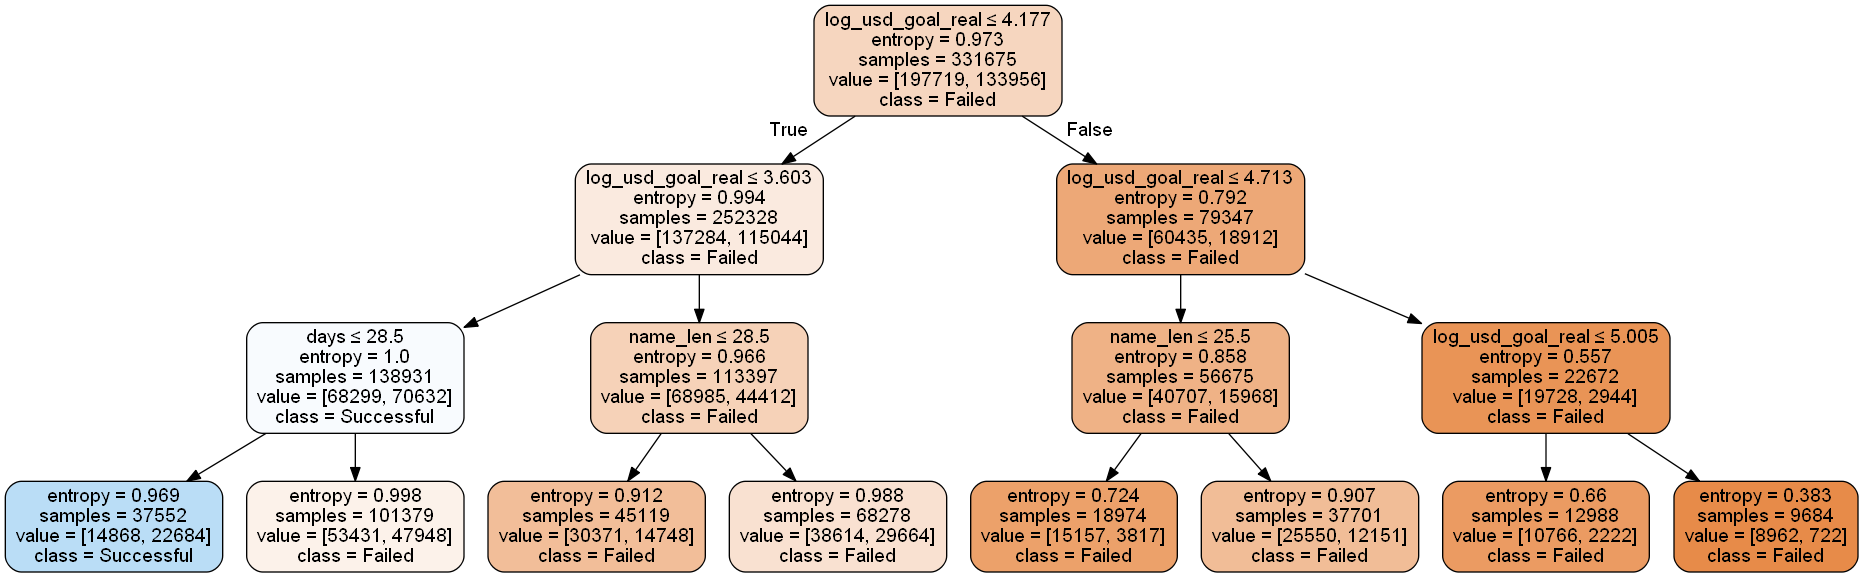

In [139]:
# 決定木の描画

dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=X_train.columns,  
                     class_names=["Failed","Successful"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())


（考察）　決定木を表示するのに、深さがNoneだと表示が終わらないので、深さは3にした。

以下の順序はどうすべきか？

- featture_namesはデータフレームX_train.columnsで取得したがこの順序であっているのか？
- class_namesはstate_boolがFalse(0),True(1)として、0,1の順で"Failed",Successful"の順で並べたがあっているのか？

### グリッドサーチ

In [141]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])


#ks_data.set_dummy()
# 質的変数のラベル化
ks_data.set_label()

df_ks_result = ks_data.get_df()

parameters = {
                'criterion':["gini","entropy"], 
                'max_depth':[3,10,20,30], 
                'min_samples_leaf':[2,4,8],
                'min_samples_split':[2,4,8]
             }
model =  model_alg = DecisionTreeClassifier(random_state=1234)
model_alg= GridSearchCV(model, parameters, cv=5)

quant_var_list = ks_data.get_quant_var_list()
valid_hold = Valid_hold(df_ks_result, model_alg, 5, quant_var_list)
clf = valid_hold.run()

print(clf.best_params_, clf.best_score_)

ホールドアウト検証結果
対数尤度 = -11.589
正答率（Accuracy） = 66.448%
適合率（Precision） = 60.719%
再現率（Recall） = 46.307%
F1値（F1-score） = 52.543%


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2} 0.6611404236074471


## 5. ランダムフォレスト

In [145]:
from sklearn.ensemble import RandomForestClassifier

ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])


#ks_data.set_dummy()
# 質的変数のラベル化
ks_data.set_label()

df_ks_result = ks_data.get_df()
y_train = df_ks_result["state_bool"]
X_train  = df_ks_result.drop("state_bool", axis=1)


score= 0.671295696088038
[0.12238462 0.14208239 0.02149077 0.39250117 0.18326755 0.0083417
 0.00909338 0.1076368  0.01320163]


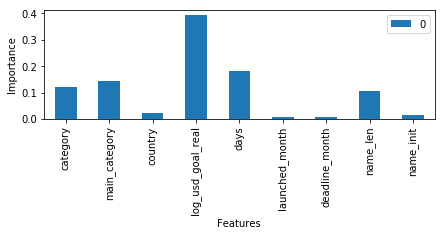

In [146]:
clf = RandomForestClassifier(n_estimators=10, max_depth=10, criterion="entropy",
                                                 min_samples_leaf=8, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X_train.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [147]:
model_alg = RandomForestClassifier(n_estimators=10, max_depth=10, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
quant_var_list = ks_data.get_quant_var_list()
valid_hold_cross = Valid_hold_cross(df_ks_result, model_alg, 5, 5, quant_var_list)
clf = valid_hold_cross.run()

0回目
対数尤度 = -11.517
正答率（Accuracy） = 66.656%
適合率（Precision） = 63.585%
再現率（Recall） = 41.552%
F1値（F1-score） = 50.260%


1回目
対数尤度 = -11.502
正答率（Accuracy） = 66.697%
適合率（Precision） = 63.957%
再現率（Recall） = 41.899%
F1値（F1-score） = 50.630%


2回目
対数尤度 = -11.555
正答率（Accuracy） = 66.545%
適合率（Precision） = 62.827%
再現率（Recall） = 42.084%
F1値（F1-score） = 50.405%


3回目
対数尤度 = -11.342
正答率（Accuracy） = 67.161%
適合率（Precision） = 63.926%
再現率（Recall） = 42.976%
F1値（F1-score） = 51.399%


4回目
対数尤度 = -11.635
正答率（Accuracy） = 66.313%
適合率（Precision） = 62.379%
再現率（Recall） = 40.748%
F1値（F1-score） = 49.295%


交差検証平均結果
対数尤度 = -11.510
正答率（Accuracy） = 66.674%
適合率（Precision） = 63.335%
再現率（Recall） = 41.852%
F1値（F1-score） = 50.398%


交差検証全訓練データによる訓練結果
対数尤度 = -11.266
正答率（Accuracy） = 67.381%
適合率（Precision） = 64.539%
再現率（Recall） = 43.001%
F1値（F1-score） = 51.613%


ホールドアウト検証結果
対数尤度 = -11.441
正答率（Accuracy） = 66.876%
適合率（Precision） = 62.933%
再現率（Recall） = 42.376%
F1値（F1-score） = 50.648%




（考察）　ランダムフォレストを使用すると、単なる木モデルに比べて、正答率はわずかに上がる。

### グリッドサーチ

In [129]:
parameters = {
                'criterion':["gini","entropy"], 
                'max_depth':[3,10,20,30], 
                'n_estimators':[5,10,20],
                'min_samples_leaf':[2,4,8],
                'min_samples_split':[2,4,8]
             }
model =  model_alg = RandomForestClassifier(random_state=1234)
model_alg= GridSearchCV(model, parameters, cv=5,)

quant_var_list = ks_data.get_quant_var_list()
valid_hold = Valid_hold(df_ks_result, model_alg, 5, quant_var_list)
clf = valid_hold.run()

print(clf.best_params_, clf.best_score_)

ホールドアウト検証結果
対数尤度 = -11.007
正答率（Accuracy） = 68.133%
適合率（Precision） = 62.855%
再現率（Recall） = 50.242%
F1値（F1-score） = 55.845%


{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20} 0.6795432275570965


（考察）　グリッドサーチでは時間がかかるが、上記のような結果が出ており、正答率他が少し上がった。

## 6. アダブースト
アダブーストを試してみる。

In [119]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])


#ks_data.set_dummy()
# 質的変数のラベル化
ks_data.set_label()

df_ks_result = ks_data.get_df()
y_train = df_ks_result["state_bool"]
X_train  = df_ks_result.drop("state_bool", axis=1)



score= 0.7078555815180523
[0.20753916 0.09504878 0.03891252 0.23571352 0.11909434 0.05287987
 0.04093673 0.12093861 0.08893645]


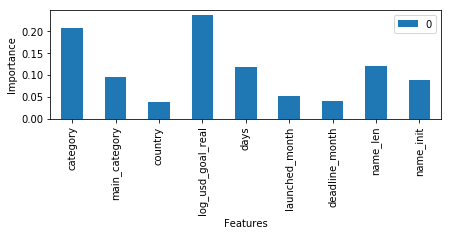

In [123]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="entropy"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X_train.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

（考察）　これをみる限り、ドル換算の目標金額と分類が効いていそう。

In [124]:
model_alg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="entropy"),
                                           n_estimators=10, random_state=1234)
quant_var_list = ks_data.get_quant_var_list()
valid_hold_cross = Valid_hold_cross(df_ks_result, model_alg, 5, 5, quant_var_list)
clf = valid_hold_cross.run()

0回目
対数尤度 = -11.311
正答率（Accuracy） = 67.251%
適合率（Precision） = 60.745%
再現率（Recall） = 54.339%
F1値（F1-score） = 57.364%


1回目
対数尤度 = -11.435
正答率（Accuracy） = 66.893%
適合率（Precision） = 60.575%
再現率（Recall） = 53.750%
F1値（F1-score） = 56.959%


2回目
対数尤度 = -11.284
正答率（Accuracy） = 67.331%
適合率（Precision） = 60.676%
再現率（Recall） = 54.361%
F1値（F1-score） = 57.345%


3回目
対数尤度 = -11.424
正答率（Accuracy） = 66.924%
適合率（Precision） = 60.163%
再現率（Recall） = 53.684%
F1値（F1-score） = 56.739%


4回目
対数尤度 = -11.398
正答率（Accuracy） = 67.001%
適合率（Precision） = 60.111%
再現率（Recall） = 53.160%
F1値（F1-score） = 56.423%


交差検証平均結果
対数尤度 = -11.370
正答率（Accuracy） = 67.080%
適合率（Precision） = 60.454%
再現率（Recall） = 53.859%
F1値（F1-score） = 56.966%


交差検証全訓練データによる訓練結果
対数尤度 = -9.752
正答率（Accuracy） = 71.767%
適合率（Precision） = 66.749%
再現率（Recall） = 60.206%
F1値（F1-score） = 63.309%


ホールドアウト検証結果
対数尤度 = -11.367
正答率（Accuracy） = 67.088%
適合率（Precision） = 59.843%
再現率（Recall） = 54.553%
F1値（F1-score） = 57.076%




（考察）　深さ10で交差検証の全訓練データに対して上記の通り。

In [126]:
model_alg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="entropy"),
                                           n_estimators=10, random_state=1234)
quant_var_list = ks_data.get_quant_var_list()
valid_hold_cross = Valid_hold_cross(df_ks_result, model_alg, 5, 5, quant_var_list)
clf = valid_hold_cross.run()

0回目
対数尤度 = -13.120
正答率（Accuracy） = 62.015%
適合率（Precision） = 53.317%
再現率（Recall） = 50.695%
F1値（F1-score） = 51.973%


1回目
対数尤度 = -13.170
正答率（Accuracy） = 61.870%
適合率（Precision） = 53.390%
再現率（Recall） = 50.717%
F1値（F1-score） = 52.019%


2回目
対数尤度 = -13.152
正答率（Accuracy） = 61.922%
適合率（Precision） = 53.023%
再現率（Recall） = 50.364%
F1値（F1-score） = 51.659%


3回目
対数尤度 = -13.122
正答率（Accuracy） = 62.009%
適合率（Precision） = 53.145%
再現率（Recall） = 50.476%
F1値（F1-score） = 51.776%


4回目
対数尤度 = -13.055
正答率（Accuracy） = 62.203%
適合率（Precision） = 53.104%
再現率（Recall） = 50.863%
F1値（F1-score） = 51.959%


交差検証平均結果
対数尤度 = -13.124
正答率（Accuracy） = 62.004%
適合率（Precision） = 53.196%
再現率（Recall） = 50.623%
F1値（F1-score） = 51.877%


交差検証全訓練データによる訓練結果
対数尤度 = -2.679
正答率（Accuracy） = 92.243%
適合率（Precision） = 91.408%
再現率（Recall） = 89.213%
F1値（F1-score） = 90.297%


ホールドアウト検証結果
対数尤度 = -13.074
正答率（Accuracy） = 62.148%
適合率（Precision） = 52.914%
再現率（Recall） = 51.118%
F1値（F1-score） = 52.001%




（考察）　深さを20にすると、さらに過学習になっているように思われる。

アダブーストは直列な計算のため、ランダムフォレストに比べて、計算がかかった。（よって、グリッドサーチは行わなかった。）

## 7. ニューラルネットワーク

In [31]:
from tensorflow.keras.utils import to_categorical
# テストデータ、訓練データの標準化
def trans_stdsc(X_train,X_test,quant_var_list):
    for item in quant_var_list:
        stdsc = StandardScaler()
        X_train.loc[:,item]  = stdsc.fit_transform(X_train[item].to_numpy().reshape(-1,1).astype('float64'))       
        X_test.loc[:,item]  = stdsc.transform(X_test[item].to_numpy().reshape(-1,1).astype('float64')) 
    return X_train, X_test

# one-hotベクトルへの変換
def trans_onehot(y_train,y_test):
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return y_train, y_test
    
# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
rms = RMSprop(lr=0.01)
adag = Adagrad(lr=0.01)
adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

In [32]:
ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])

# 質的変数のダミー化
ks_data.set_dummy()
# 質的変数のラベル化
# ks_data.set_label()

df_ks_result = ks_data.get_df()
y = df_ks_result["state_bool"]
X  = df_ks_result.drop("state_bool", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

quant_var_list = ks_data.get_quant_var_list()

# 量的変数の標準化
X_train, X_test = trans_stdsc(X_train, X_test, quant_var_list)

    
# one-hotベクトルに変換
y_train, y_test = trans_onehot(y_train,y_test)


C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [37]:
model = Sequential()
model.add(Dense(400, activation='relu', input_dim=353))
model.add(Dense(300, activation='relu', input_dim=400))
model.add(Dense(100, activation='relu', input_dim=300))
model.add(Dense(50, activation='relu', input_dim=100))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと


model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

最初のDenseのinput_dimは説明変数の数に合わせる必要がある。

Train on 232172 samples, validate on 99503 samples
Epoch 1/50
232172/232172 [==============================] - 31s 133us/sample - loss: 0.6037 - acc: 0.6688 - val_loss: 0.5983 - val_acc: 0.6700
Epoch 2/50
232172/232172 [==============================] - 31s 132us/sample - loss: 0.6223 - acc: 0.6455 - val_loss: 0.6744 - val_acc: 0.5975
Epoch 3/50
232172/232172 [==============================] - 31s 133us/sample - loss: 0.6753 - acc: 0.5955 - val_loss: 0.6748 - val_acc: 0.5975
Epoch 4/50
232172/232172 [==============================] - 31s 132us/sample - loss: 0.6753 - acc: 0.5955 - val_loss: 0.6748 - val_acc: 0.5975
Epoch 5/50
232172/232172 [==============================] - 31s 134us/sample - loss: 0.6753 - acc: 0.5955 - val_loss: 0.6766 - val_acc: 0.5975
Epoch 6/50
232172/232172 [==============================] - 31s 132us/sample - loss: 0.6753 - acc: 0.5955 - val_loss: 0.6740 - val_acc: 0.5975
Epoch 7/50
232172/232172 [==============================] - 31s 133us/sample - loss: 0.6754

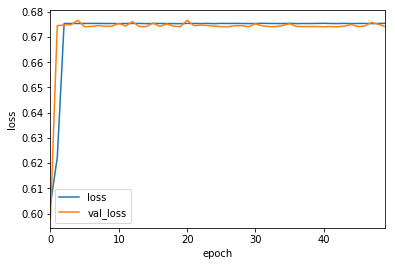

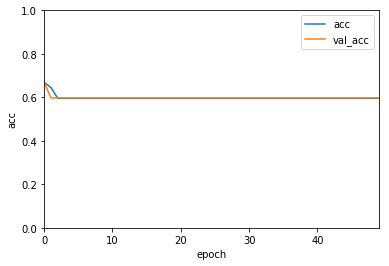

In [38]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

（考察）

途中で学習が止まっているように思われる。

epoc数は10以下で十分？

#### モデルの簡素化とepoc数を減らす

In [39]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=353))
model.add(Dense(50, activation='relu', input_dim=200))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

model.compile(loss='categorical_crossentropy',
              optimizer=adad,
              metrics=['accuracy'])


Train on 232172 samples, validate on 99503 samples
Epoch 1/10
232172/232172 [==============================] - 19s 83us/sample - loss: 0.6314 - acc: 0.6340 - val_loss: 0.6122 - val_acc: 0.6568
Epoch 2/10
232172/232172 [==============================] - 19s 82us/sample - loss: 0.6070 - acc: 0.6633 - val_loss: 0.6017 - val_acc: 0.6688
Epoch 3/10
232172/232172 [==============================] - 19s 82us/sample - loss: 0.5994 - acc: 0.6708 - val_loss: 0.5968 - val_acc: 0.6734
Epoch 4/10
232172/232172 [==============================] - 19s 83us/sample - loss: 0.5952 - acc: 0.6740 - val_loss: 0.5939 - val_acc: 0.6761
Epoch 5/10
232172/232172 [==============================] - 19s 82us/sample - loss: 0.5925 - acc: 0.6765 - val_loss: 0.5920 - val_acc: 0.6772
Epoch 6/10
232172/232172 [==============================] - 19s 82us/sample - loss: 0.5906 - acc: 0.6777 - val_loss: 0.5907 - val_acc: 0.6781
Epoch 7/10
232172/232172 [==============================] - 19s 82us/sample - loss: 0.5891 - acc:

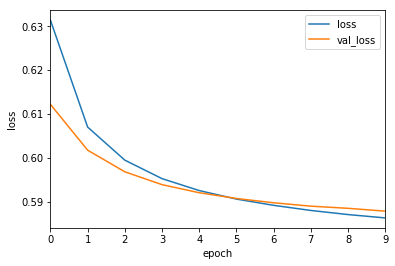

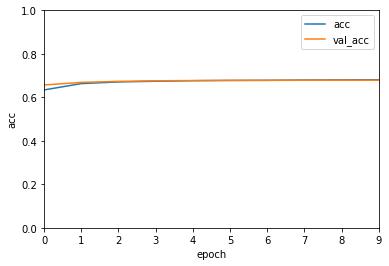

In [40]:

# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=10,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

(考察）　とりあえずニューラルネットワークを使用してみたが、他の手法と明確な正答率の差異は感じられない。

おそらくグリッドサーチをすべきだが、計算時間がかかりすぎて、数が試せない。

#### 特徴量選択との組み合わせ
埋め込み法で説明変数を減らして、同じモデルで計算してみる。

In [41]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

ks_data = Ks_data()

# 量的変数の設定
ks_data.set_quant_var(["log_usd_goal_real","days","name_len"])

# 質的変数の設定
ks_data.set_quality_var(["category","main_category","country","name_init","launched_month","deadline_month"])

# 質的変数のダミー化
ks_data.set_dummy()

df_ks_result = ks_data.get_df()


df_label = df_ks_result["state_bool"]
df_data = df_ks_result.drop("state_bool", axis=1)

y = df_label.values
X = df_data.values

# fitで特徴選択を実行
sfm.fit(X, y)

# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()

# 削除すべき特徴を削除して計算してみる。
delete_item = df_data.columns[removed_idx]

In [42]:
y = df_ks_result["state_bool"]
X  = df_ks_result.drop("state_bool", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

quant_var_list = ks_data.get_quant_var_list()

# 量的変数の標準化
X_train, X_test = trans_stdsc(X_train, X_test, quant_var_list)

# 削除対象の特徴量を削除    
X_train = X_train.drop(delete_item,axis=1)
X_test = X_test.drop(delete_item,axis=1)

# one-hotベクトルに変換
y_train, y_test = trans_onehot(y_train,y_test)

C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [43]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=311))
model.add(Dense(50, activation='relu', input_dim=200))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

model.compile(loss='categorical_crossentropy',
              optimizer=adad,
              metrics=['accuracy'])

Train on 232172 samples, validate on 99503 samples
Epoch 1/10
232172/232172 [==============================] - 18s 79us/sample - loss: 0.6296 - acc: 0.6372 - val_loss: 0.6117 - val_acc: 0.6593
Epoch 2/10
232172/232172 [==============================] - 18s 78us/sample - loss: 0.6065 - acc: 0.6644 - val_loss: 0.6009 - val_acc: 0.6701
Epoch 3/10
232172/232172 [==============================] - 18s 78us/sample - loss: 0.5988 - acc: 0.6721 - val_loss: 0.5962 - val_acc: 0.6749
Epoch 4/10
232172/232172 [==============================] - 18s 78us/sample - loss: 0.5948 - acc: 0.6752 - val_loss: 0.5936 - val_acc: 0.6764
Epoch 5/10
232172/232172 [==============================] - 18s 78us/sample - loss: 0.5923 - acc: 0.6770 - val_loss: 0.5919 - val_acc: 0.6774
Epoch 6/10
232172/232172 [==============================] - 18s 78us/sample - loss: 0.5905 - acc: 0.6781 - val_loss: 0.5908 - val_acc: 0.6781
Epoch 7/10
232172/232172 [==============================] - 18s 78us/sample - loss: 0.5892 - acc:

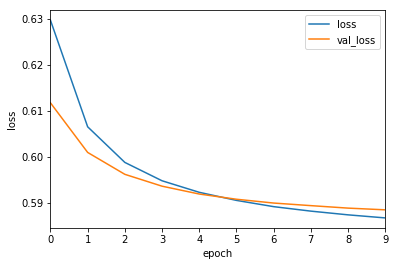

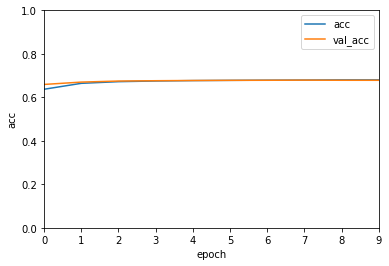

In [44]:

# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=10,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

（考察）　特徴量を減らしてもあまり結果は変わらなかった。

### ニューラルネットワークまとめ

- 層の数やDenseを変えて何度かやってみたが、改善するパラメータが明確にはわからない。
- 同じモデルを使用しても、過学習を起こしたり、起こさなかったりし、結果が安定していないこともある。
- 計算に時間が結構かかるため、複数のモデルを試すのに時間がかかる。
    - いくつかモデルを用意して、バッチ処理させた方が良さそう。
- ロジスティック回帰に比べて、明確に結果がよくなったわけではなかった。
- 特徴量を減らしてもあまり結果は変わらなかった。